# 3. Modélisation avec un RNN

Dans cette section, nous allons séparer les données en deux ensembles : un pour l'entrainement et un pour le test. Ensuite, nous allons construire un modèle de réseau de neurones récurrent (RNN) pour classer les commentaires YouTube en fonction de leur toxicité.

### Architecture du modèle
Nous utilisons une architecture RNN simple avec les couches suivantes :
- Embedding : pour convertir les mots en vecteurs denses.
- LSTM ou GRU : pour capturer les dépendances séquentielles dans les textes.
- Dense : pour classifier chaque commentaire comme toxique ou non toxique.

Dans un premier temps nous allons récupérer les données prétraitées et le tokenizer que nous avons sauvegardé dans la section précédente.

In [52]:
# Récupération des données prétraitées et du tokenizer :
import pickle
from keras.models import load_model

# Chargement des données prétraitées et du tokenizer :
with open('../data/cleaned_dataset.pickle', 'rb') as f:
    data = pickle.load(f)

with open('../src/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [53]:
data.head()

,split,toxicity,toxicity_label,padded_sequences
0,train,0.373134,0,"[22, 178, 38, 121, 73, 22, 214, 8, 490, 2635, ..."
1,train,0.605263,1,"[1689, 434, 32, 1458, 196, 2, 110, 8, 751, 180..."
2,train,0.666667,1,"[5, 29, 1141, 38, 5412, 5477, 39, 15, 296, 17,..."
3,test,0.815789,1,"[177, 7555, 4, 160, 12, 6559, 2055, 30, 10, 1,..."
4,train,0.550000,1,"[17864, 5, 1089, 14, 227, 820, 192, 1506, 1, 0..."


In [54]:
print(data['toxicity_label'].value_counts())
print(f"Nombre de commentaires toxiques : {data['toxicity_label'].value_counts()[1]}")

0    435407
1    137164
Name: toxicity_label, dtype: int64
Nombre de commentaires toxiques : 137164


Il existe plusieurs méthodes pour pallier au problème de déséquilibre de classes comme :
- Undersampling : réduire la taille de la classe majoritaire.
- Class weights : donner plus de poids à la classe minoritaire.

Nous allons faire une combinaison des deux méthodes en utilisant les class weights et en réduisant la taille de la classe majoritaire.

In [55]:
data['toxicity_label'].value_counts()

0    435407
1    137164
Name: toxicity_label, dtype: int64

In [56]:
# Nous allons réduire de moitié la taille des données train ayant un label 0 pour équilibrer les données :

r = 2
data_0 = data[data['toxicity_label'] == 0].sample(n=data[data['toxicity_label'] == 1].shape[0]*r)
data_1 = data[data['toxicity_label'] == 1]

data = data_0.append(data_1)

C:\Users\helle\AppData\Local\Temp\ipykernel_24272\3834063438.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_0.append(data_1)


In [58]:
print(data[(data['toxicity_label'] == 0) & (data['split'] == 'train')].shape)
print(data[(data['toxicity_label'] == 1) & (data['split'] == 'train')].shape)
print(data[(data['toxicity_label'] == 0) & (data['split'] == 'test')].shape)
print(data[(data['toxicity_label'] == 1) & (data['split'] == 'test')].shape)

(247788, 4)
(123882, 4)
(26540, 4)
(13282, 4)


In [59]:
import numpy as np

# Séparation des données en deux ensembles : un pour l'entraînement et un pour le test

dataset_train=data[data.split=='train']
dataset_test=data[data.split=='test']

dataset_train.drop('split',axis=1,inplace=True)
dataset_test.drop('split',axis=1,inplace=True)

dataset_train.drop('toxicity',axis=1,inplace=True)
dataset_test.drop('toxicity',axis=1,inplace=True)

y_train = np.array(dataset_train['toxicity_label'])
y_test = np.array(dataset_test['toxicity_label'])

X_train = np.array(dataset_train['padded_sequences'].tolist())
X_test = np.array(dataset_test['padded_sequences'].tolist())

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

C:\Users\helle\AppData\Local\Temp\ipykernel_24272\3433046696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_train.drop('split',axis=1,inplace=True)
C:\Users\helle\AppData\Local\Temp\ipykernel_24272\3433046696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_test.drop('split',axis=1,inplace=True)
C:\Users\helle\AppData\Local\Temp\ipykernel_24272\3433046696.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data

(371670, 100) (371670,) (39822, 100) (39822,)


In [60]:
# only take 10% of the data for training randomly
proportion = 0.2
np.random.seed(42)

train_indices = np.random.choice(X_train.shape[0], int(proportion * X_train.shape[0]), replace=False)
test_indices = np.random.choice(X_test.shape[0], int(proportion * X_test.shape[0]), replace=False)

X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Garder autant de commentaires non toxiques que de commentaires toxiques en utilisant un échantillon aléatoire pour le test set

toxic_indices = np.where(y_test == 1)[0]
non_toxic_indices = np.where(y_test == 0)[0]

test_indices = np.concatenate([toxic_indices, np.random.choice(non_toxic_indices, len(toxic_indices), replace=False)])

X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(74334, 100) (74334,) (26564, 100) (26564,)


In [62]:
# count the number of 0 and 1 in the training set
class_0 = len(y_train[y_train == 0])
class_1 = len(y_train[y_train == 1])

print("Number of 0 in training set: ", class_0)
print("Number of 1 in training set: ", class_1)

# count the number of 0 and 1 in the test set
print("Number of 0 in test set: ", len(y_test[y_test == 0]))
print("Number of 1 in test set: ", len(y_test[y_test == 1]))

Number of 0 in training set:  49561
Number of 1 in training set:  24773
Number of 0 in test set:  13282
Number of 1 in test set:  13282


Création du modèle RNN :


In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall

# Définition des hyperparamètres
vocab_size = 25000       # Taille maximale du vocabulaire (nombre de mots uniques pris en compte)
max_length = 100         # Longueur maximale des séquences (post-padding/truncating)
embedding_dim = 128       # Dimensionnalité des vecteurs d'embedding
lstm_units = 64          # Nombre d'unités dans chaque couche LSTM
dropout_rate = 0.3       # Taux de dropout pour la régularisation
learning_rate = 0.001    # Taux d'apprentissage pour l'optimiseur

# Construction du modèle de classification
model = Sequential([
    # Couche d'embedding pour transformer les indices en vecteurs
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
 
    # Première couche LSTM bidirectionnelle avec retour de séquences
    Bidirectional(LSTM(lstm_units, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.01))),
    Dropout(0.1),  # Régularisation pour éviter le surapprentissage

    # # Deuxième couche LSTM bidirectionnelle sans retour de séquences
    # LSTM(lstm_units, activation='tanh', kernel_regularizer=l2(0.01)),
    # Dropout(0.1),  # Ajout d'une deuxième couche de dropout

    # Couche fully connected avec activation ReLU
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Couche de sortie pour la classification binaire
    Dense(1, activation='sigmoid')
    
    # pour une classification continue, on peut utiliser une couche Dense(1) avec activation 'linear'
    # Dense(1, activation='linear')
])

# Compilation du modèle
model.compile(
    loss='binary_crossentropy',             # Fonction de perte pour les tâches de classification binaire
    optimizer=Adam(learning_rate=learning_rate),  # Optimiseur Adam avec un taux d'apprentissage défini
    metrics=['accuracy']                    # Métrique utilisée pour évaluer les performances
)

# continue
# model.compile(
#     loss='mean_squared_error',  # Utilise MSE pour des scores continus
#     optimizer='adam',          # Optimiseur Adam (bon pour des tâches complexes)
#     metrics=['mae']            # Facultatif : métrique d'évaluation supplémentaire
# )


# Afficher un résumé du modèle
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

### Calcul des poids pour classes déséquilibrées

Pour calculer les poids à utiliser pour les classes déséquilibrées, nous utilisons la méthode suivante :

#### Données du problème

- Classe `0` : 157343 occurrences
- Classe `1` : 49533 occurrences

On divise le nombre total de données par le nombre de données de chaque classe pour obtenir les poids :

N = nombre total de données,
n_0 = nombre d'échantillons dans la classe 0,
n_1 = nombre d'échantillons dans la classe 1

- w_0 = N/n_0
- w_1 = N/n_1

Pour éviter que les poids deviennent trop élevés ou difficiles à interpréter, vous pouvez normaliser les poids en divisant chaque poids par la somme des poids

In [64]:
N_total = len(y_train)
w_0 = N_total / class_0
w_1 = N_total / class_1

w_0_normalized = w_0 / (w_0 + w_1)
w_1_normalized = w_1 / (w_0 + w_1)

arrondi = 2
w_0_normalized = round(w_0_normalized, arrondi)
w_1_normalized = round(w_1_normalized, arrondi)

print("Weight for class 0: ", w_0/w_0)
print("Weight for class 1: ", w_1/w_0)

print("Normalized weight for class 0: ", w_0_normalized)
print("Normalized weight for class 1: ", w_1_normalized)

Weight for class 0:  1.0
Weight for class 1:  2.0006054979211236
Normalized weight for class 0:  0.33
Normalized weight for class 1:  0.67


In [65]:
# Entrainement du modèle
from tensorflow.keras.callbacks import EarlyStopping

class_weights = {0: 1, 1: 2}  # Par exemple, donner plus de poids aux commentaires toxiques


history = model.fit(
    X_train, y_train,            # Données d'entrée et de sortie
    epochs=5,                    # Nombre d'itérations sur l'ensemble des données
    batch_size=32,               # Nombre d'échantillons utilisés pour estimer le gradient
    validation_split=0.2,        # 20% des données utilisées pour la validation
    verbose=1,                   # Affichage des logs
    class_weight=class_weights,  # Poids pour les classes
)



Epoch 1/5
1859/1859 [==============================] - 156s 82ms/step - loss: 0.8544 - accuracy: 0.6802 - val_loss: 0.4552 - val_accuracy: 0.7942
Epoch 2/5
1859/1859 [==============================] - 141s 76ms/step - loss: 0.5771 - accuracy: 0.8169 - val_loss: 0.4604 - val_accuracy: 0.8064
Epoch 3/5
1859/1859 [==============================] - 142s 77ms/step - loss: 0.5018 - accuracy: 0.8467 - val_loss: 0.4944 - val_accuracy: 0.7805
Epoch 4/5
1859/1859 [==============================] - 149s 80ms/step - loss: 0.4420 - accuracy: 0.8639 - val_loss: 0.4723 - val_accuracy: 0.7981
Epoch 5/5
1859/1859 [==============================] - 166s 89ms/step - loss: 0.3885 - accuracy: 0.8795 - val_loss: 0.5538 - val_accuracy: 0.7878


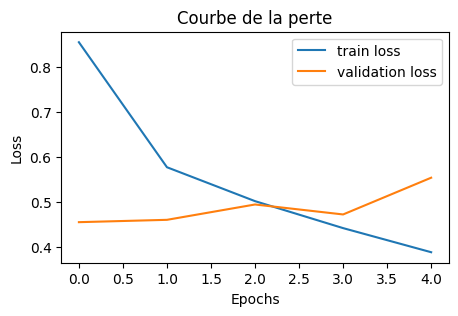

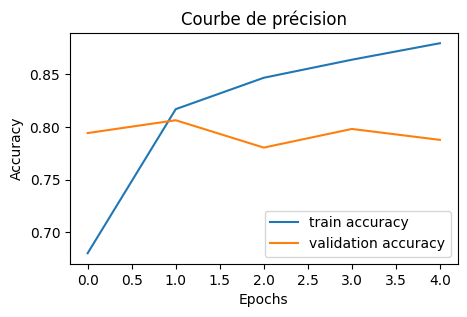

In [66]:
import matplotlib.pyplot as plt

# Courbe de perte
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Courbe de la perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Courbe de précision
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Courbe de précision')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [67]:
# Evaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss sur le jeu de test : {loss}")
print(f"Précision sur le jeu de test : {accuracy}")

831/831 [==============================] - 11s 13ms/step - loss: 0.6206 - accuracy: 0.7852
Loss sur le jeu de test : 0.6206105351448059
Précision sur le jeu de test : 0.7851603627204895


On remarque que notre modèle a une précision de 0.78 sur les données de test. Cepandant, la précision n'est pas une bonne métrique pour les problèmes de classification déséquilibrée. Nous allons utiliser la matrice de confusion et le rapport de classification pour évaluer le modèle.

831/831 [==============================] - 11s 13ms/step


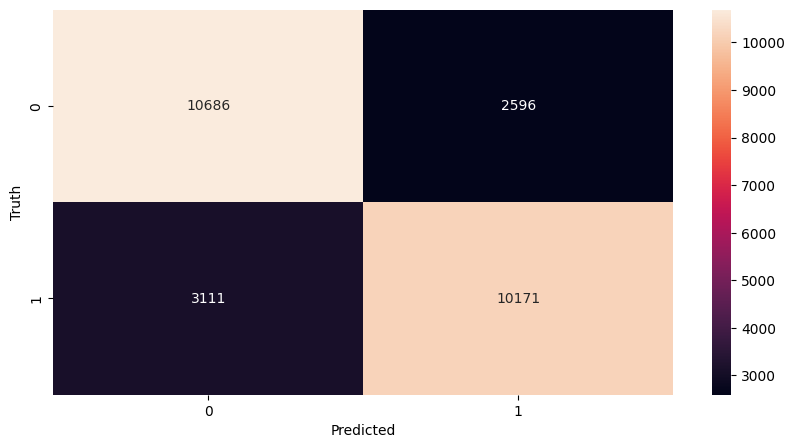

In [68]:
# Prédiction sur le jeu de test avec une matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test > 0.5, y_pred > 0.5)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [69]:
# Calcul de la précision, du rappel et du score F1
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test > 0.5, y_pred > 0.5)
recall = recall_score(y_test > 0.5, y_pred > 0.5)
f1 = f1_score(y_test > 0.5, y_pred > 0.5)

print(f"Précision : {precision}", f"Rappel : {recall}", f"Score F1 : {f1}", sep='\n')

Précision : 0.7966632724994126
Rappel : 0.7657732269236561
Score F1 : 0.7809128949287881


La précision est définie comme le nombre de prédictions correctes divisé par le nombre total de prédictions. Cependant, dans le cas de classes déséquilibrées, la précision peut être élevée même si le modèle ne prédit pas bien la classe minoritaire. C'est pourquoi nous utilisons la matrice de confusion et le rapport de classification pour évaluer le modèle.

Le rappel est défini comme le nombre de vrais positifs divisé par le nombre de vrais positifs plus de faux négatifs. Le recall est une mesure de la capacité du modèle à trouver tous les échantillons positifs.

Le score F1 est la moyenne harmonique de la précision et du rappel. Il est utile pour les problèmes de classification déséquilibrée car il prend en compte à la fois la précision et le rappel et donne une mesure unique de la performance du modèle.


In [70]:
precision = cm[1][1] / (cm[1][1] + cm[0][1])
recall = cm[1][1] / (cm[1][1] + cm[1][0])
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)

print("Precision: ", precision, "\nRecall: ", recall, "\nF1 Score: ", f1)

Precision:  0.7966632724994126 
Recall:  0.7657732269236561 
F1 Score:  0.7809128949287881


In [74]:
# save the model and its weights
model.save('../src/model/toxicity_model_1.h5')

# 5. Inférence sur de nouveaux commentaires

Une fois le modèle entraîné, il est temps de le tester sur des exemples concrets pour évaluer sa capacité à prédire la toxicité des commentaires.
Nous allons également charger le tokenizer sauvegardé pour prétraiter les textes avant l'inférence.

In [72]:
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

#remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop_words]
    return ' '.join(result)

def process_comment(comment):
    
    # On met le texte en minuscule
    comment = comment.lower()
    
    # On retire les balises HTML, les caractères spéciaux et les espaces multiples
    comment = re.sub(r'<.*?>', '', comment)  # Supprimer les balises HTML
    comment = re.sub(r'[^a-zA-Z\s]', '', comment)  # Garder uniquement les lettres
    comment = re.sub(r'\s+', ' ', comment).strip()  # Supprimer les espaces multiples
    comment = comment.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
    
    # On retire les stop words
    tokens = word_tokenize(comment)
    final_tokens = comment.split()
    
    # On lemmatize les mots
    wordlem = WordNetLemmatizer()
    finalwords = []
    for w in final_tokens:
        word = wordlem.lemmatize(w)
        finalwords.append(word)

    return ' '.join(finalwords)

In [73]:
# Charger le tokenizer sauvegardé

with open('../src/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

# Fonction de prétraitement et tokenisation
def preprocess_text(text, tokenizer, max_length):
    # Nettoyage (comme précédemment)
    text_cleaned = process_comment(text)
    # Conversion en séquence numérique
    sequence = tokenizer.texts_to_sequences([text_cleaned])
    # Appliquer le padding
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    return padded_sequence

# Exemple de nouveaux commentaires
new_comments = [
    "I love this video, it was very helpful!",
    "This is the worst content I've ever seen. Total garbage!",
    "You should die, you idiot.",
    "I am the best president ever"
]

# Prédictions
for comment in new_comments:
    preprocessed_comment = preprocess_text(comment, tokenizer, max_length)
    prediction = model.predict(preprocessed_comment)[0][0]  # [0][0] pour extraire la valeur
    toxicity = "Toxic" if prediction > 0.5 else "Non-Toxic"
    print(f"Comment: {comment}")
    print(f"Predicted Toxicity: {toxicity} (Score: {prediction:.2f})\n")


1/1 [==============================] - 0s 24ms/step
Comment: I love this video, it was very helpful!
Predicted Toxicity: Non-Toxic (Score: 0.01)

1/1 [==============================] - 0s 25ms/step
Comment: This is the worst content I've ever seen. Total garbage!
Predicted Toxicity: Toxic (Score: 0.98)

1/1 [==============================] - 0s 22ms/step
Comment: You should die, you idiot.
Predicted Toxicity: Toxic (Score: 1.00)

1/1 [==============================] - 0s 24ms/step
Comment: I am the best president ever
Predicted Toxicity: Non-Toxic (Score: 0.04)

